In [1]:
import csv
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.stats as stats
import numpy as np

In [2]:
#基礎的線性內插法
def intersectx(x1, y1, x2, y2, targety):
    return x1 + (x2 - x1)/ (y2 - y1) * (targety -y1)

def intersecty(x1, y1, x2, y2, targetx):
    return y1 + (y2 - y1)/ (x2 - x1) * (targetx - x1)

In [21]:
class LHCPmeasure:
    def __init__(self, file):
        with open(file, "r") as filename:
            self.cpgain = list(csv.reader(filename))
            self.Dk = []
            self.lhzero = []
            self.lhninety = []
            for j in range(500):
                zero = []
                ninety = []
                self.Dk.append(float(self.cpgain[0][2*j+1].split("Dk='")[1].split("'")[0]))
                for i in range(1, 268):   ##注意:這裡取用的不是全部的序列
                    zero.append(float(self.cpgain[i][2*j+1]))
                    ninety.append(float(self.cpgain[i][2*j+2]))
                self.lhzero.append(zero)
                self.lhninety.append(ninety)
            self.lhzeroLocalMax = []
            for lhzero in self.lhzero:
                former = lhzero[0]
                localMax = dict()
                localls = []
                deg = []
                for i in range(1, len(lhzero)-1):
                    if (former < lhzero[i]) and (lhzero[i] > lhzero[i+1]):
                        localMax[lhzero[i]] = i-180
                        localls.append(lhzero[i])
                        deg.append(i)
                    former = lhzero[i]
                self.lhzeroLocalMax.append((localMax, localls, deg))

            self.lhzeroLocalMin = []
            for lhzero in self.lhzero:
                former = lhzero[0]
                localMin = dict()
                localls = []
                deg = []
                for i in range(1, len(lhzero)-1):
                    if (former > lhzero[i]) and (lhzero[i] < lhzero[i+1]):
                        localMin[lhzero[i]] = i-180
                        localls.append(lhzero[i])
                        deg.append(i)
                    former = lhzero[i]
                self.lhzeroLocalMin.append((localMin, localls, deg))
                  
    def lhzeromainLobe(self):
        allDk = self.lhzeroLocalMax
        out = []
        for i in range(len(allDk)):
            localMax, localls, deg = allDk[i][0], allDk[i][1], allDk[i][2]
            lhzero = self.lhzero[i]
            globalMax = max(localMax.keys())
            k = deg[localls.index(globalMax)]
            m = k
            # 低點
            while lhzero[k] > globalMax-3 :
                k -= 1
            LF = intersectx(k-180, lhzero[k], k-179, lhzero[k+1], globalMax-3)
            # 高點
            while lhzero[m] > globalMax -3 :
                m += 1
            HF = intersectx(m-180, lhzero[m], m-181, lhzero[m-1], globalMax-3)
            BW = HF - LF
            out.append((globalMax, LF, HF, BW))
        return out
    
    def lhzeroLeftSideLobe(self):
        allDk = self.lhzeroLocalMax
        out = []
        for i in range(len(allDk)):
            localMax, localls, deg = allDk[i][0], allDk[i][1], allDk[i][2]
            lhzero = self.lhzero[i]
            globalMax = max(localMax.keys())
            x = deg[localls.index(globalMax)-1]
            y = x 
            #print(localls.index(globalMax)+1)
            while lhzero[y] > localls[localls.index(globalMax)-1]-3 :
                y += 1
            #print(y-180, lhzero[k])
            HF = intersectx(y-180, lhzero[y], y-181, lhzero[y-1], localls[localls.index(globalMax)-1]-3)
          #  print(HF)
            z = x
            while lhzero[z] > localls[localls.index(globalMax)-1]-3 :
                z -= 1
            LF = intersectx(z-180, lhzero[z], z-179, lhzero[z-1], localls[localls.index(globalMax)-1]-3)
          #  print(LF)
            out.append((localls[localls.index(globalMax)-1], LF, HF, HF-LF))
        return out

In [22]:
cplobegain = LHCPmeasure('Datasets/500資料版/左手圓極化 Gain Plot.csv')

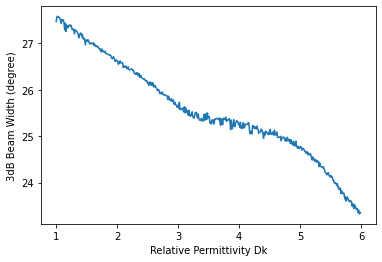

In [23]:
# Main Lobe 3dB Beam Width
B = []
x = cplobegain.lhzeromainLobe()
for i in range(500):
    B.append(x[i][3])

plt.plot(cplobegain.Dk, B)
plt.xlabel("Relative Permittivity Dk")
plt.ylabel("3dB Beam Width (degree)")
plt.show()

In [6]:
# 全部曲線加以考量
print('Correlation Coefficient of Dk and Main Lobe 3dB Beam Width =',stats.pearsonr(cplobegain.Dk, B)[0])
print('')

# 分段後的結果 -- 前 1.00 <= Dk <= 3.30 
print('Correlation Coefficient of Dk and Main Lobe 3dB Beam Width (Dk = 1.00~3.30) =',stats.pearsonr(cplobegain.Dk[0:231], B[0:231])[0])
args1 = np.polyfit(cplobegain.Dk[0:231], B[0:231], 1)
print("Prediction Equation : y1 =", args1[0],"x +", args1[1])
print('')

# 分段後的結果 -- 後 5.00 <= Dk <= 6.00 
print('Correlation Coefficient of Dk and Main Lobe 3dB Beam Width (Dk = 5.00~600) =',stats.pearsonr(cplobegain.Dk[400:], B[400:])[0])
args2 = np.polyfit(cplobegain.Dk[400:], B[400:], 1)
print("Prediction Equation : y2 =", args2[0],"x +", args2[1])

Correlation Coefficient of Dk and Main Lobe 3dB Beam Width = -0.9834569843450618

Correlation Coefficient of Dk and Main Lobe 3dB Beam Width (Dk = 1.00~3.30) = -0.9980144807254862
Prediction Equation : y1 = -0.9386429844375036 x + 28.494819578847398

Correlation Coefficient of Dk and Main Lobe 3dB Beam Width (Dk = 5.00~600) = -0.9958834005149342
Prediction Equation : y2 = -1.5042113618496489 x + 32.35635517335582


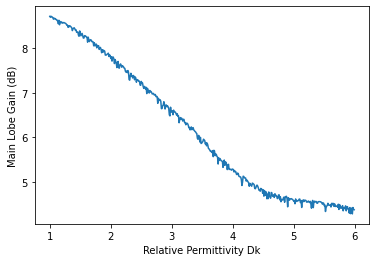

In [7]:
# Main Lobe Gain
Max = []
#x = cplobegain.lhzeromainLobe()
for i in range(500):
    Max.append(x[i][0])
plt.plot(cplobegain.Dk, Max)
plt.xlabel("Relative Permittivity Dk")
plt.ylabel("Main Lobe Gain (dB)")
plt.show()

In [8]:
# 全部曲線加以考量
print('Correlation Coefficient of Dk and Main Lobe Gain =',stats.pearsonr(cplobegain.Dk, Max)[0])
print('')

# 分段後的結果 -- 前 1.00 <= Dk <= 3.30 
print('Correlation Coefficient of Dk and Main Lobe Gain (Dk = 1.00~3.30) =',stats.pearsonr(cplobegain.Dk[0:231], Max[0:231])[0])
args3 = np.polyfit(cplobegain.Dk[0:231], Max[0:231], 1)
print("Prediction Equation : y3 =", args3[0],"x +", args3[1])
print('')

# 分段後的結果 -- 後3.40 <= Dk <= 4.00 
print('Correlation Coefficient of Dk and Main Lobe Gain (Dk = 3.50~4.00) =',stats.pearsonr(cplobegain.Dk[240:301], Max[240:301])[0])
args4 = np.polyfit(cplobegain.Dk[240:301], Max[240:301], 1)
print("Prediction Equation : y4 =", args4[0],"x +", args4[1])

Correlation Coefficient of Dk and Main Lobe Gain = -0.9820959030463754

Correlation Coefficient of Dk and Main Lobe Gain (Dk = 1.00~3.30) = -0.9963871229739694
Prediction Equation : y3 = -1.1229372740016905 x + 9.988305261637866

Correlation Coefficient of Dk and Main Lobe Gain (Dk = 3.50~4.00) = -0.9791214373069037
Prediction Equation : y4 = -1.3697721624745982 x + 10.707360730728526


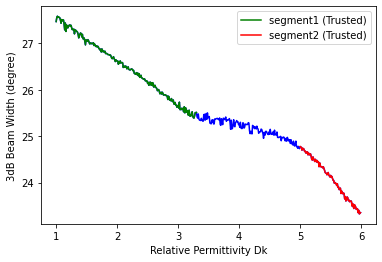

In [9]:
# 個別做出之全部範圍與信任區間
plt.plot(cplobegain.Dk, B, 'b')
plt.xlabel("Relative Permittivity Dk")
plt.ylabel("3dB Beam Width (degree)")

plt.plot(cplobegain.Dk[0:231], B[0:231], 'g', label = 'segment1 (Trusted)')
plt.plot(cplobegain.Dk[400:], B[400:], 'r', label = 'segment2 (Trusted)')
plt.legend()
plt.show()

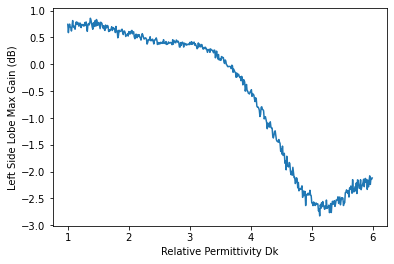

In [10]:
# Left Side Lobe Max Gain
LS = []
x = cplobegain.lhzeroLeftSideLobe()
for i in range(500):
    LS.append(x[i][0])

plt.plot(cplobegain.Dk, LS)
plt.xlabel("Relative Permittivity Dk")
plt.ylabel("Left Side Lobe Max Gain (dB)")
plt.show()

In [11]:
# 全部曲線加以考量
print('Correlation Coefficient of Dk and Main Lobe Gain =',stats.pearsonr(cplobegain.Dk, LS)[0])
print('')

# 分段後的結果 --  3.60 <= Dk <= 5.00 
print('Correlation Coefficient of Dk and Main Lobe Gain (Dk = 3.60~5.00) =',stats.pearsonr(cplobegain.Dk[260:401], LS[260:401])[0])
args5 = np.polyfit(cplobegain.Dk[260:401], LS[260:401], 1)
print("Prediction Equation : y5 =", args5[0],"x +", args5[1])

Correlation Coefficient of Dk and Main Lobe Gain = -0.9307676250777218

Correlation Coefficient of Dk and Main Lobe Gain (Dk = 3.60~5.00) = -0.9932539977300041
Prediction Equation : y5 = -1.988773569941961 x + 7.350783294293288


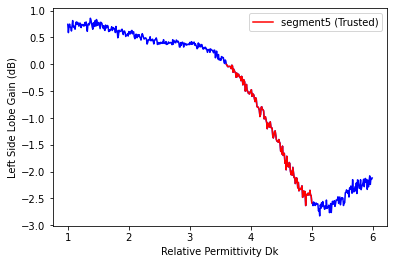

In [12]:
# 個別做出之全部範圍與信任區間
plt.plot(cplobegain.Dk, LS, 'b')
plt.xlabel("Relative Permittivity Dk")
plt.ylabel("Left Side Lobe Gain (dB)")

plt.plot(cplobegain.Dk[260:401], LS[260:401], 'r', label = 'segment5 (Trusted)')
plt.legend()
plt.show()

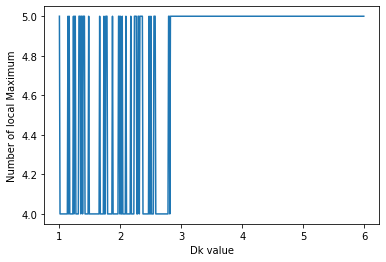

In [13]:
localMaxNum = []
for ele in cplobegain.lhzeroLocalMax:
    localMaxNum.append(len(ele[0]))

plt.plot(cplobegain.Dk, localMaxNum)
plt.xlabel('Dk value')
plt.ylabel('Number of local Maximum')
plt.show()  
##特別注意 Dk 2.81的 Boundary

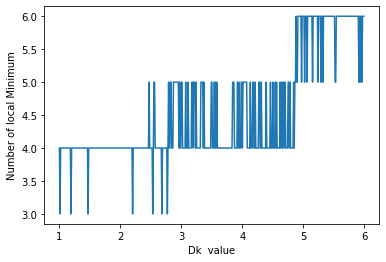

In [14]:
localMinNum = []
for ele in cplobegain.lhzeroLocalMin:
    localMinNum.append(len(ele[0]))

plt.plot(cplobegain.Dk, localMinNum)
plt.xlabel('Dk  value')
plt.ylabel('Number of local Minimum')
plt.show()  
##特別注意 Dk 2.47, 2.77, 4.88的 Boundary

In [15]:
localMinNum[0]

4

In [16]:
localMaxNum[0]

5